# Análisis Exploratorio de datos 

## Importación de librerias y creación de funciones

In [106]:
# Importar las bibliotecas necesarias
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch
import seaborn as sns
from yellowbrick.cluster import silhouette_visualizer

In [107]:
def cargar_csv(ruta_csv):
    try:
        df = pd.read_csv(ruta_csv)
        return df
    except FileNotFoundError:
        print(f"El archivo en la ruta {ruta_csv} no se encontró.")
    except pd.errors.EmptyDataError:
        print("El archivo CSV está vacío.")
    except pd.errors.ParserError:
        print("Error al analizar el archivo CSV.")
    except Exception as e:
        print(f"Ocurrió un error: {e}")

In [108]:
def graficar_histograma(df, y, x, ax):
    sns.histplot(data=df[df[y] == 1], x=x, bins=20, kde=True, color='green', label='1', ax=ax)
    sns.histplot(data=df[df[y] == 0], x=x, bins=20, kde=True, color='red', label='0', ax=ax)
    
    ax.set_xlabel(f'{x}')
    ax.set_ylabel('Frecuencia')
    ax.set_title(f'Histograma de Frecuencia - Precipitación de lluvia acumulada en {x}')
    ax.legend()

In [109]:
def crear_tabla_contingencia(df, columna1, columna2):

    tabla_contingencia = pd.crosstab(df[columna1], df[columna2]).reset_index(drop=False)
    tabla_contingencia.index.name = None
    tabla_contingencia.columns.name = None
    tabla_contingencia=tabla_contingencia.sort_values(by=0,ascending=False)
    return tabla_contingencia

In [110]:
df=cargar_csv(os.path.join('..','Data','output','train_data_1.csv'))

In [111]:
df.head()

,ELEVACION,PENDIENT,zonificacion,Nomenclatura_del_Suelo,tipo_geologia,24h,7d,10d,15d,30d,60d,90d,deslizamientos
0,1030.110840,21.268663,Riesgo medio,Zonas urbanas continuas,Formacion Volcanica,14.0,197.0,210.0,366.0,583.0,746.0,908.0,1
1,1176.433594,56.848099,Riesgo alto,Zonas urbanas continuas,Formacion Guachinte,7.6,83.5,110.0,213.5,343.7,452.1,531.0,1
2,1038.540527,32.060978,Riesgo bajo,Zonas urbanas continuas,Formacion Guachinte,9.5,91.2,117.0,215.4,266.2,331.3,434.0,1
3,1657.118408,47.167477,Amenaza baja,Bosque mixto abierto alto de tierra firme,Formacion Volcanica,0.0,26.0,42.0,53.0,93.0,198.0,293.0,1
4,980.576721,20.477095,Riesgo bajo,Zonas urbanas continuas,Formacion Guachinte,11.0,11.2,12.3,39.4,43.9,175.5,323.0,0


## Variables Numéricas

Primeramente, es común en problema de clasificación revisar si se trata de un problema de clases desbalanceadas o no. El desbalance de datos en el aprendizaje automático ocurre cuando hay muchas más muestras de una clase que de otra. Por ejemplo, en este caso, si queremos detectar deslizamientos de tierra y la mayoría de los registros reportan un no deslizamiento, puede ser difícil para un modelo identificar los deslizamientos porque tiene menos ejemplos para aprender de ellos. Es importante revisar esto al explorar los datos para asegurarse de que el modelo pueda hacer predicciones precisas y útiles. Sin abordar este desbalance, el modelo podría no funcionar correctamente. 

  

Para esto haremos una revisión simple de cuantos registros hay de cada clase 

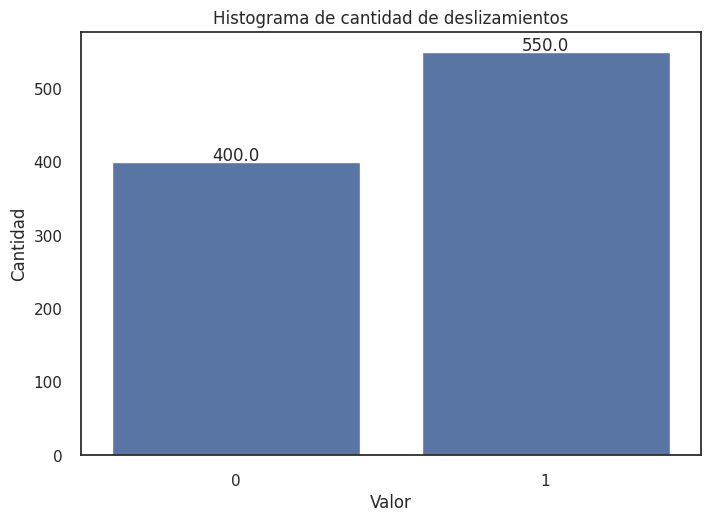

In [112]:
# Grafica el histograma usando Seaborn.
ax=sns.countplot(data=df, x='deslizamientos')

# Añade etiquetas y título
plt.xlabel('Valor')
plt.ylabel('Cantidad')
plt.title('Histograma de cantidad de deslizamientos')
# Agrega los valores en las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

Donde 0 representa la clase negativa que es "No Deslizamiento de tierra" en punto geográfico 
y 1 representa la clase positiva que es "Deslizamiento de tierra" 

Esta es la lógica que seguiremos en las implementaciones. 

Como podemos ver, no se presenta un problema grande de desbalance, ya que hay una relación de aproximadamente 40/60 de cada tipo de clase, por lo general se establece que hay desbalance de clases cuando hay una relación 10/90. Pero vemos que este no es el caso 

Ahora vemos cómo se comportan las variables de precipitación de lluvia respecto la variable objetivo 

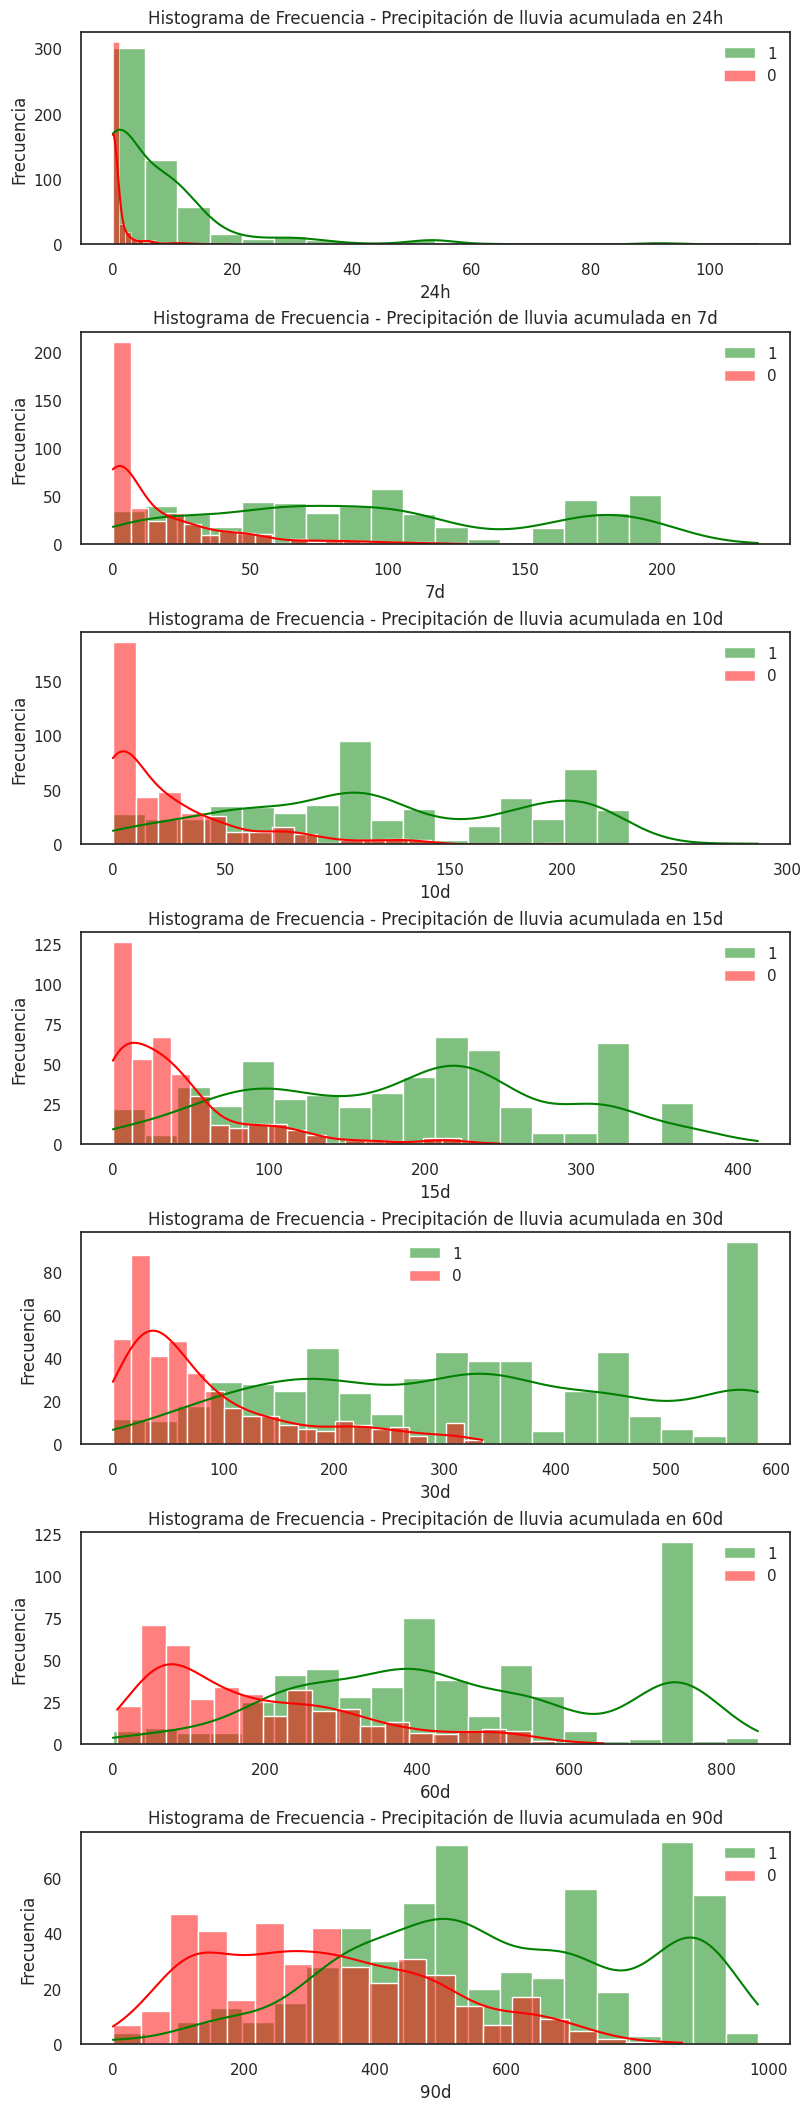

In [113]:
columnas_a_graficar = ['24h', '7d', '10d','15d','30d','60d','90d'] 
n = len(columnas_a_graficar)
fig, axes = plt.subplots(n, 1, figsize=(8, 3 * n), constrained_layout=True)
if n == 1:
    axes = [axes]
for columna, ax in zip(columnas_a_graficar, axes):
    graficar_histograma(df, y='deslizamientos', x=columna, ax=ax)
plt.show()

En este caso vemos que para puntos donde ha habido deslizamientos de tierra, existe mayor cantidad de lluvia acumulada en mm en comparación con los que no han presentado deslizamientos. Esto nos sugiere que las variables de precipitación son importantes para estimar si existe deslizamientos o no   

También podremos pensar que al tratarse de variables que capturan data de manera acumulada, puede haber valor que da una variable que también lo de otra, podemos revisar las correlaciones entre las precipitaciones

## Variables categóricas

Ahora veamos las relaciones de las variables categoricas con el objetivo

In [114]:
resultados = {}
columnas_comparar=['zonificacion','Nomenclatura_del_Suelo','tipo_geologia']
for c in columnas_comparar:
    tabla = crear_tabla_contingencia(df, c, 'deslizamientos')
    resultados[c] = tabla

In [115]:
resultados['zonificacion']

,zonificacion,0,1
5,Riesgo bajo,206,169
1,Amenaza baja,194,15
0,Amenaza alta,0,26
2,Amenaza media,0,27
3,Amenaza muy alta,0,3
4,Riesgo alto,0,206
6,Riesgo medio,0,104


In [116]:
resultados['Nomenclatura_del_Suelo']

,Nomenclatura_del_Suelo,0,1
25,Zonas urbanas continuas,98,401
20,Pasto cultivado arbolado,50,9
19,Pasto cultivado,38,10
26,Zonas urbanas discontinuas,36,25
8,Bosque mixto denso bajo de tierra firme,25,9
21,Pasto cultivado enmalezado,20,3
9,Bosque mixto fragmentado con pastos y cultivos,18,0
15,Otras superficies artificiales con construcción,15,1
24,Vegetación secundaria o transición,14,11
7,Bosque mixto denso alto de tierra firme,13,14


In [117]:
resultados['tipo_geologia']

,tipo_geologia,0,1
8,Formacion Jamundi,96,3
10,Lateritas Formacion Volcanica,86,113
9,Formacion Volcanica,84,345
1,Cono aluvial 2 rio Pance,37,1
0,Cono aluvial 1 rio Pance,28,0
2,Cono aluvial rio Melendez,20,5
7,Formacion Guachinte,20,79
6,Formacion Ferreira,15,0
4,Depositos aluviales,7,1
3,Conos aluviales,3,1


Las variables categóricas con muy pocas frecuencias pueden presentar varios desafíos y consideraciones, por ejemplo: 
  

- Sobre-ajuste: Las categorías que aparecen solo unas pocas veces pueden llevar a modelos que se ajustan demasiado a esos casos específicos, capturando el ruido en lugar de patrones generales. Esto puede disminuir la capacidad de generalización del modelo a datos no vistos.  


- Estabilidad en el entrenamiento: Dado que el modelo tiene pocos ejemplos de estas categorías, puede ser difícil para el modelo aprender patrones representativos. Las categorías con baja frecuencia pueden no tener suficientes datos para permitir que el modelo aprenda características significativas, lo que puede llevar a una mala representación de esas categorías en el modelo. 


Todo esto puede afectar en las métricas de evaluación, como la precisión, el recall, y la F1-score, ya que el rendimiento en estas categorías raras puede no estar bien representado 

## Análisis Cluster

En este análisis, se implementará un análisis de clustering como parte del análisis exploratorio para las variables predictoras. El objetivo principal será identificar y entender los perfiles ocultos que existen en los datos de entrenamiento, con el fin de extraer conclusiones valiosas sobre la estructura subyacente de las muestras.

Se utilizarán técnicas de clustering como K-Means para agrupar los datos en función de sus características, sin considerar la variable objetivo. Esto permitirá descubrir patrones, segmentaciones y grupos homogéneos que podrían ofrecer perspectivas adicionales, facilitando la comprensión del problema de clasificación y sugiriendo posibles mejoras en las estrategias de modelado predictivo.

In [118]:
independent_var_erase=[] # Eliminamos la variable de precipitacion acumulada a 10 dias
dependent_var='deslizamientos'
independent_var=[x for x in df.columns if x not in independent_var_erase and x not in dependent_var]
X=df[independent_var]
y=df[dependent_var]
# Seleccionar columnas categoricas
VAR_categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

# Seleccionar columnas numericas
VAR_numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

label_encoders = {}
for feature in VAR_categorical_cols:
    le = LabelEncoder()
    X[feature] = le.fit_transform(X[feature])
    label_encoders[feature] = le

In [119]:
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

In [120]:
X_scaled.head()

,ELEVACION,PENDIENT,zonificacion,Nomenclatura_del_Suelo,tipo_geologia,24h,7d,10d,15d,30d,60d,90d
0,-0.566235,-0.470035,1.215925,0.635991,0.385252,0.854159,2.144217,1.791373,2.273389,1.997366,1.824370,1.770709
1,0.105551,1.203249,0.118416,0.635991,-0.395942,0.250162,0.327085,0.400193,0.834211,0.671545,0.499336,0.223749
2,-0.527533,0.037522,0.667170,0.635991,-0.395942,0.429474,0.450362,0.497575,0.852142,0.242164,-0.045285,-0.174275
3,2.312436,0.747974,-1.527849,-2.257647,0.385252,-0.467084,-0.593488,-0.545810,-0.680465,-0.717435,-0.646261,-0.752847
4,-0.793653,-0.507262,0.667170,0.635991,-0.395942,0.571035,-0.830436,-0.958990,-0.808812,-0.989469,-0.747701,-0.629747


Escalamos el conjunto de datos para evitar el sesgo debido a escalas diferentes, mejorar la convergencia de K-Means y garantizar la consistencia en la métrica de distancia

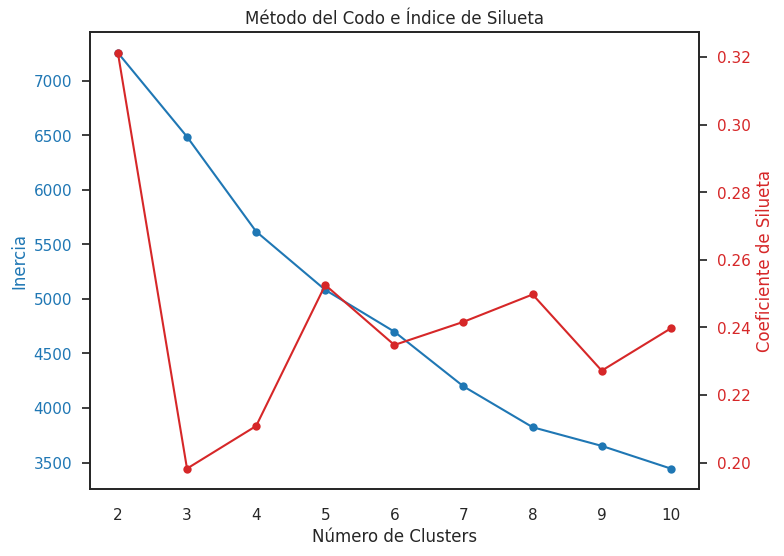

In [121]:
# Inercia para el Método del Codo
inertia = []
# Coeficiente de Silueta
silhouette_scores = []
n_clusters_range = range(2, 11) # de 2 a 10 cluster
clusters_dict = {}

for n in n_clusters_range:
    kmeans = KMeans(n_clusters=n,init='k-means++')
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

    # Crear un DataFrame con los datos escalados y la columna "clusters"
    df_with_clusters = X.copy()
    df_with_clusters['clusters'] = labels

    # Guardar en el diccionario con la clave como el número de clusters
    clusters_dict[f'con_{n}_clusters'] = df_with_clusters

# Graficar ambos
fig, ax1 = plt.subplots()

ax1.set_xlabel('Número de Clusters')
ax1.set_ylabel('Inercia', color='tab:blue')
ax1.plot(n_clusters_range, inertia, marker='o', color='tab:blue', label='Inercia')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()  # Crear un segundo eje que comparte el eje x
ax2.set_ylabel('Coeficiente de Silueta', color='tab:red')
ax2.plot(n_clusters_range, silhouette_scores, marker='o', color='tab:red', label='Coef. de Silueta')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Método del Codo e Índice de Silueta')
plt.show()

Utilizaremos el método del codo (`Inercia`) y el `Coeficiente de Silueta` para identificar el número de clusters más optimo. 


Este método evalúa la suma de los errores cuadrados dentro de cada cluster (inertia) para diferentes valores de n_clusters. A medida que aumenta el número de clusters, la inercia disminuye, pero llega un punto en el que la mejora se vuelve marginal. El "codo" en la gráfica es el punto donde el incremento de clusters deja de ofrecer una mejora significativa. 

El coeficiente de silueta mide la separación entre los clusters y qué tan bien están asignadas las muestras dentro de su propio cluster. Los valores del coeficiente de silueta están entre -1 y 1, donde un valor cercano a 1 indica que los puntos están bien agrupados. 


En este mismo orden de las ideas, tenemos que encontrar ese número que nos indique el codo en la serie de la inercia (línea azul) y el coeficiente de silueta más alto en la serie de silueta (línea roja). Vemos que el punto que cumple con esta condición es el 7 

In [122]:
resultado_cluster=clusters_dict['con_7_clusters']
resultado_cluster.head()

,ELEVACION,PENDIENT,zonificacion,Nomenclatura_del_Suelo,tipo_geologia,24h,7d,10d,15d,30d,60d,90d,clusters
0,1030.110840,21.268663,6,25,9,14.0,197.0,210.0,366.0,583.0,746.0,908.0,3
1,1176.433594,56.848099,4,25,7,7.6,83.5,110.0,213.5,343.7,452.1,531.0,1
2,1038.540527,32.060978,5,25,7,9.5,91.2,117.0,215.4,266.2,331.3,434.0,1
3,1657.118408,47.167477,1,5,9,0.0,26.0,42.0,53.0,93.0,198.0,293.0,2
4,980.576721,20.477095,5,25,7,11.0,11.2,12.3,39.4,43.9,175.5,323.0,4


In [123]:
funciones_agregacion = ['mean', 'median', 'count', 'min', 'max']
agg_dict = {col: funciones_agregacion for col in resultado_cluster.columns if 'clusters' not in col}
resultado = resultado_cluster.groupby('clusters').agg(agg_dict)
resultado

ELEVACION                                                PENDIENT  \
                 mean       median count          min          max       mean   
clusters                                                                        
0         1100.253703  1079.523193    81   982.548950  1386.967896  24.632541   
1         1074.935264  1070.924927   197   979.613403  1599.939087  37.993050   
2         1698.509124  1690.444214   103  1305.648315  2098.276855  35.253831   
3         1080.719655  1063.546631   140   985.792114  1769.932861  43.140712   
4         1094.907349  1060.142578   243   972.612610  1500.505249  27.524975   
5         1155.213916  1170.223389    35   975.132202  1712.018311  30.145108   
6         1073.816093  1061.876465   151   975.396118  1430.414063  18.580224   

                                                 ...         60d               \
             median count       min         max  ...        mean median count   
clusters                                         ...                            
0         18.411295    81  2.978758   92.066528  ...  405.806173  400.8    81   
1         36.388821   197  1.330287   94.294182  ...  474.485279  446.1   197   
2         27.692619   103  1.930219  101.956207  ...  246.880583  265.0   103   
3         42.952623   140  3.538649   89.237999  ...  677.208571  735.0   140   
4         22.076199   243  1.231035   84.404579  ...  169.339095  172.3   243   
5         28.641380    35  8.977777   55.786831  ...  446.937143  408.0    35   
6         15.210188   151  0.984309   63.939667  ...  138.431788   98.3   151   

                               90d                             
            min    max        mean median count    min    max  
clusters                                                       
0         234.0  753.0  561.907407  561.0    81  255.0  869.0  
1         256.0  848.0  599.757360  531.0   197  333.8  972.0  
2          23.0  521.4  385.794175  364.0   103  103.0  815.6  
3         446.0  753.0  834.200000  878.0   140  666.0  918.0  
4           0.0  483.2  283.686008  300.0   243    0.0  660.0  
5         215.0  731.5  634.228571  600.0    35  284.0  984.0  
6           0.0  374.3  273.660927  261.0   151    0.0  572.0  

[7 rows x 60 columns]

Vemos el perfil de la variable de lluvia acumulada en las ultimas 24h

In [124]:
resultado['24h']

,mean,median,count,min,max
clusters,,,,,
0,2.786420,0.0,81,0.0,30.0
1,5.197970,1.2,197,0.0,24.4
2,2.865049,0.0,103,0.0,29.2
3,6.715714,10.0,140,0.0,16.0
4,1.878189,0.0,243,0.0,23.6
5,47.640000,42.0,35,29.0,108.0
6,0.615894,0.0,151,0.0,14.0


Observamos que para el cluster 0, 2, 4 y 5 podría representar aquel grupo con niveles de lluvias acumuladas más bajos, mientras que los cluster numero 1, 3 y 6 con los mayores niveles al observar sus medidas de agrupación.

Ahora observemos la variable de `PENDIENT`

In [130]:
resultado['PENDIENT']

,mean,median,count,min,max
clusters,,,,,
0,24.632541,18.411295,81,2.978758,92.066528
1,37.993050,36.388821,197,1.330287,94.294182
2,35.253831,27.692619,103,1.930219,101.956207
3,43.140712,42.952623,140,3.538649,89.237999
4,27.524975,22.076199,243,1.231035,84.404579
5,30.145108,28.641380,35,8.977777,55.786831
6,18.580224,15.210188,151,0.984309,63.939667


el cluster 0,4 y 6 son los que representan agrupan esos registros que representan terrenos con menos porcentajes de pendientes. 

Aunque sean bastantes cluster, se evidencia que la mayoría de cluster apuntan a 2 agrupamientos, es decir que nos tratan de decir que hay 2 clases de población dentro de nuestro conjunto de datos 

## Correlaciones entre variables independientes

Queremos que exista la menor correlación lineal y no lineal entre las variables independientes, ya que queremos que cada variable aporte su valor único al modelo, y evitar redundancias

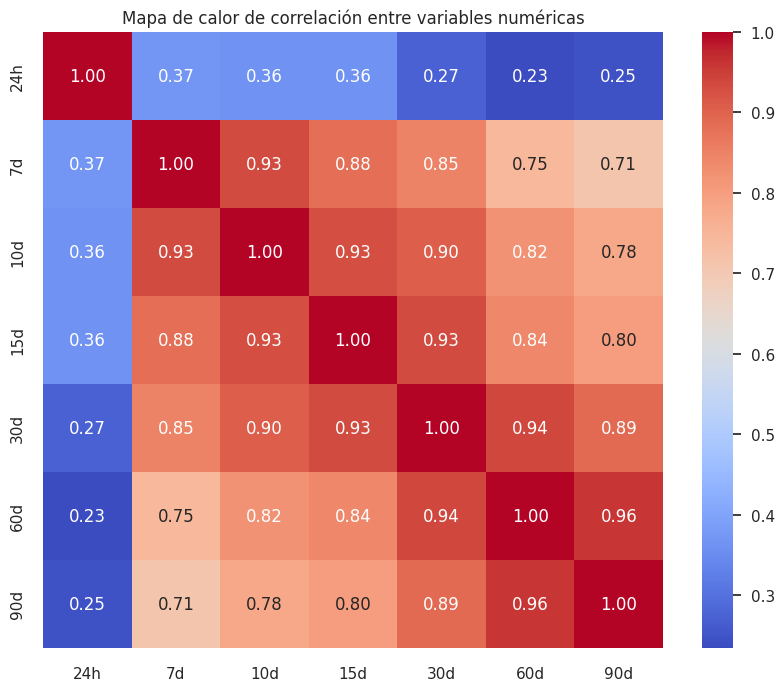

In [127]:
# Correlaciones entre variables independientes
correlation_matrix = df[columnas_a_graficar].corr(method='pearson')

# Configurar el estilo del mapa de calor

sns.set(style="white")

# Crear el mapa de calor de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Añadir título
plt.title('Mapa de calor de correlación entre variables numéricas')

# Mostrar el mapa de calor
plt.show()

Observamos que existe una alta correlación lineal entre las variables númericas de precipitación, dándonos a entender que no son del todo independientes y que a medida que suben los dias (10 dias, 15 dias, 30 dias y así sucesivamente) aumenta su dependencia.


Esto genera multicolinealidad, lo que puede hacer que los coeficientes en modelos lineales (como la regresión logística, que se modelará en este analisis) se vuelvan inestables y difíciles de interpretar, esto ocurre porque el modelo no puede distinguir fácilmente el efecto individual de cada variable correlacionada. 


Tambien se podria explorar como se ve la matriz de correlaciones, eliminando algunas variables para hacer mas grande la brecha que separa los dias acumulados, es decir en ves de usar una variable como `7d` y `10d`, usar variables que representen brechas de acumulacion de lluvia mas grande para tratar de disminuir la multicolinealidad

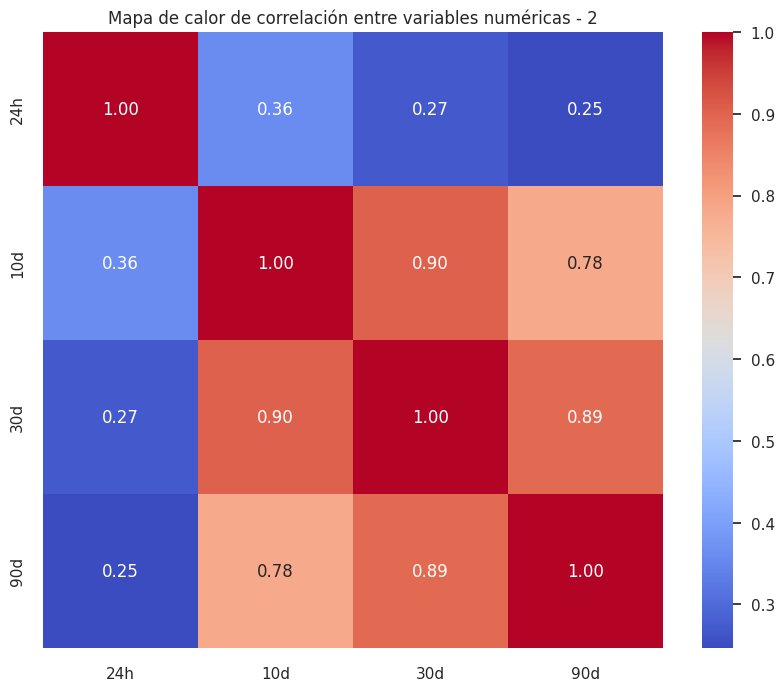

In [128]:
columnas_a_graficar2 = ['24h','10d','30d','90d'] 
# Correlaciones entre variables independientes
correlation_matrix = df[columnas_a_graficar2].corr(method='pearson')

# Configurar el estilo del mapa de calor

sns.set(style="white")

# Crear el mapa de calor de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Añadir título
plt.title('Mapa de calor de correlación entre variables numéricas - 2')

# Mostrar el mapa de calor
plt.show()

Al eliminar ciertas variables, el mapa de calor se torna menos rojo, es decir hay menos variables que nos aportan multicolinealidad. Este conjunto de variables se pueden evaluar para la selecicon de features a tomar en cuenta para cada modelo. 

Las variables altamente correlacionadas aportan información redundante. Esto puede hacer que el modelo sea más complejo de lo necesario, sin mejorar el rendimiento predictivo, lo cual puede llevar a un modelo sobre ajustado que no generaliza bien a datos nuevos. En algunos casos, los algoritmos de clasificación que se usarán en este análisis, como los árboles de decisión o los modelos basados en conjuntos (e.g., Random Forest, XGBoost), no se ven tan afectados por la multicolinealidad, pero la presencia de variables altamente correlacionadas puede todavía llevar a un modelo más complejo de lo necesario.

## Decisiones

Del EDA podemos concluir que sería bueno eliminar ciertas variables numéricas debido a la alta redundancia entre las mismas, esta decisión dependerá del modelo a utilizar, ya que esto afecta de maneras diferentes cada modelo. En cuanto a las variables categóricas se decidirá trabajar con todas, se usará un codificador de etiquetas y no un one-hot encoder debido a la cantidad de clases que puede tomar una categoría.  

  

La data de entrenamiento puede variar dependiendo del modelo a usar y los rendimientos de este 